In [79]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import requests
import random
import bs4 as bs
import datetime
import yfinance as yf
# from pandas_datareader import data as pdr
# from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader
from pandas_datareader.yahoo.daily import YahooDailyReader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize
import array_to_latex as a2l
from sklearn.preprocessing import StandardScaler

"""
Own packages
"""

from codelib.population_parameters import calculate_mean, calculate_cov_mat, corr_to_cov_matrix, project_logreturns_dist_params, calculate_mu_linear_returns, calculate_cov_mat_linear_returns, cov_to_corr_and_vols
from codelib.portfolio_measures import portfolio_mean, portfolio_variance, portfolio_std
from codelib.portfolio_performance_measures import sharpe_ratio
from codelib.portfolio_optimizers import calculate_max_sharpe_portfolio, calculate_min_var_portfolio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Afkastforventninger.dk
afkastforventinger 1H2023 for forskellige investeringsklasser på kort sigt (1-5 år)

In [1100]:
corr_mat = np.array([[1.0,0.6,0.1,0.3,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1],
[0.6,1.0,0.6,0.6,0.2,0.2,0.2,0.1,0.1,0.3],
[0.1,0.6,1.0,0.7,0.7,0.6,0.6,0.4,0.3,0.7],
[0.3,0.6,0.7,1.0,0.5,0.6,0.4,0.2,0.2,0.5],
[-0.1,0.2,0.7,0.5,1.0,0.7,0.8,0.4,0.4,0.8],
[-0.1,0.2,0.6,0.6,0.7,1.0,0.7,0.4,0.4,0.7],
[-0.2,0.2,0.6,0.4,0.8,0.7,1.0,0.4,0.4,0.7],
[-0.1,0.1,0.4,0.2,0.4,0.4,0.4,1.0,0.3,0.4],
[-0.1,0.1,0.3,0.2,0.4,0.4,0.4,0.3,1.0,0.4],
[-0.1,0.3,0.7,0.5,0.8,0.7,0.7,0.4,0.4,1.0]])
vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094]) #std.
returns_yearly = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038]) #linear returns
assets = ["GB","IGB","HYB","EMGB","EDM","EEM","PE","IS","RE","HF"]
num_assets = len(returns_yearly)
rf = 0

In [780]:
# situation med 0 i korrelation
corr_mat = np.diag(np.diag(corr_mat))

In [1101]:
# calculate monthly linear-return parameters
cov_mat_logreturns_yearly = corr_to_cov_matrix(corr_mat, vols)
mu_logreturns_yearly = returns_yearly.T - 1/2 * np.diag(cov_mat_logreturns_yearly)
(mu_logreturns_monthly, cov_mat_logreturns_monthly) = project_logreturns_dist_params(mu_logreturns_yearly, cov_mat_logreturns_yearly, 12, 1)
mu = calculate_mu_linear_returns(mu_logreturns_monthly, cov_mat_logreturns_monthly)
cov_mat = calculate_cov_mat_linear_returns(mu_logreturns_monthly, cov_mat_logreturns_monthly)
vols = np.sqrt(np.diag(cov_mat))
vols_mat = np.diag(vols)
corr_mat = cov_mat / np.outer(vols, vols)
corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1

# Fama-French 10 and 49 Industry Portfolios (highly correlated because they are equity indices)

In [839]:
ff_10_returns = pd.read_csv(r'C:\code\masters_thesis\data\10industry_mc_monthly_returns.csv', index_col='Date')
mu = np.mean(ff_10_returns, axis=0)
assets = ff_10_returns.columns
num_assets = len(mu)
print(mu)
cov_mat = np.cov(ff_10_returns.T) #normalized by N-1 by default
print(cov_mat)
vols = np.sqrt(np.diag(cov_mat))
vols_mat = np.diag(vols)
corr_mat = cov_mat / np.outer(vols, vols)
corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1
print(corr_mat)
rf = 0

NoDur    0.917526
Durbl    1.039948
Manuf    1.033411
Enrgy    1.007786
HiTec    1.219792
Telcm    0.686927
Shops    1.011354
Hlth     1.001016
Utils    0.848411
Other    0.947917
dtype: float64
[[14.40494086 15.25948603 13.52843849 11.78612689 11.70040027 11.60171092
  12.00714435 10.81756335  8.46766708 14.40987186]
 [15.25948603 64.99404908 28.89449261 23.82833957 33.00569007 22.11792464
  25.92776743 15.04040214 10.19176676 30.58323018]
 [13.52843849 28.89449261 23.42476718 20.02366188 22.95702761 16.68074994
  17.28174994 12.95224457  9.09454643 22.02839694]
 [11.78612689 23.82833957 20.02366188 43.54342668 16.87355411 15.33748717
  12.2815863  10.36382889 12.66384608 19.82569355]
 [11.70040027 33.00569007 22.95702761 16.87355411 46.22298481 22.93724296
  21.70463762 15.47163233  6.0843558  22.90047293]
 [11.60171092 22.11792464 16.68074994 15.33748717 22.93724296 25.79297696
  15.16031331 12.05348433  8.16584915 18.57862256]
 [12.00714435 25.92776743 17.28174994 12.2815863  21.70

In [840]:
# med 0 i korrelation
cov_mat = np.diag(np.diag(cov_mat))
vols = np.sqrt(np.diag(cov_mat))
vols_mat = np.diag(vols)
corr_mat = cov_mat / np.outer(vols, vols)
corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1

In [85]:
ff_49_returns = pd.read_csv(r'C:\code\masters_thesis\data\49industry_mc_monthly_returns.csv', index_col='Date')/100
rf = 0
mu = np.mean(ff_49_returns, axis=0)
assets = ff_49_returns.columns
num_assets = len(mu)
cov_mat = np.cov(ff_49_returns.T) #normalized by N-1 by default
corr_mat, vols_mat = cov_to_corr_and_vols(cov_mat)
print(corr_mat)

[[1.         0.33493572 0.20867142 ... 0.40961385 0.48374215 0.33976316]
 [0.33493572 1.         0.47101532 ... 0.40291513 0.41203154 0.43498772]
 [0.20867142 0.47101532 1.         ... 0.47040953 0.41508475 0.41382728]
 ...
 [0.40961385 0.40291513 0.47040953 ... 1.         0.63611377 0.58611998]
 [0.48374215 0.41203154 0.41508475 ... 0.63611377 1.         0.62324029]
 [0.33976316 0.43498772 0.41382728 ... 0.58611998 0.62324029 1.        ]]


# Simulation study

In [3]:
# calculate true max sharpe portfolio (true optima from linear return parameters)
w_max_sr = calculate_max_sharpe_portfolio(mu, cov_mat, rf)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.31946096051192197
            Iterations: 14
            Function evaluations: 700
            Gradient evaluations: 14


In [4]:
np.round(w_max_sr,4)

array([ 0.0755, -0.    ,  0.0118,  0.1233,  0.0534, -0.    , -0.    ,
       -0.    , -0.    , -0.    , -0.    ,  0.    ,  0.1341, -0.    ,
        0.    , -0.    , -0.    , -0.    , -0.    , -0.    , -0.    ,
       -0.    , -0.    , -0.    , -0.    ,  0.2057,  0.0037, -0.    ,
        0.    , -0.    ,  0.1943, -0.    , -0.    , -0.    , -0.    ,
        0.1082,  0.0121,  0.    , -0.    , -0.    , -0.    , -0.    ,
        0.0495,  0.0284, -0.    ,  0.    , -0.    , -0.    , -0.    ])

In [5]:
# calculate expected return, variance, std. and Sharpe-ratio for the true optimal MV portfolio

mu_max_sr = portfolio_mean(w_max_sr, mu)
print("mu_max_sr = " + str(mu_max_sr))
var_max_sr = portfolio_variance(w_max_sr, cov_mat)
print("sigma^2_max_sr = " + str(var_max_sr))
std_max_sr = portfolio_std(w_max_sr, cov_mat)
print("sigma_max_sr = " + str(std_max_sr))
sr_max_sr = sharpe_ratio(mu_max_sr, var_max_sr, rf)
print("SR_max_sr = " + str(sr_max_sr))

mu_max_sr = 0.010979810618428544
sigma^2_max_sr = 0.0011812834312980277
sigma_max_sr = 0.03436980406254926
SR_max_sr = 0.31946096051192197


In [1105]:
# simulate log-returns from multivariate normal distribution and transform into linear returns

num_sim = 1000
num_obs = 60 # months
np.random.seed(2)
sim_log_returns = np.random.multivariate_normal(mu_logreturns_monthly, cov_mat_logreturns_monthly, size=(num_sim, num_obs))
sim_returns = np.exp(sim_log_returns) - 1

# estimate optimal weights for each simulation
w_sim = np.zeros((num_sim, num_assets))
mu_est = np.mean(sim_returns, axis=1)

for k in range(num_sim):

    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    w_sim[k,:] = calculate_max_sharpe_portfolio(mu_est[k],cov_mat_est,rf)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.4039170397042191
            Iterations: 12
            Function evaluations: 136
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3192348647840996
            Iterations: 14
            Function evaluations: 155
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.4424253098459537
            Iterations: 11
            Function evaluations: 125
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5716925023289412
            Iterations: 13
            Function evaluations: 147
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3897825461608282
            Iterations: 13
            Fun

In [6]:
num_sim = 1000
num_obs = 60 # months
np.random.seed(2)
print(cov_mat)
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

# estimate optimal weights for each simulation
w_sim = np.zeros((num_sim, num_assets))
mu_est = np.mean(sim_returns, axis=1)

for k in range(num_sim):

    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    w_sim[k,:] = calculate_max_sharpe_portfolio(mu_est[k],cov_mat_est,rf=0)

[[0.00387756 0.00084521 0.00086188 ... 0.00193038 0.00205053 0.00130911]
 [0.00084521 0.0016423  0.00126609 ... 0.00123575 0.00113665 0.00109074]
 [0.00086188 0.00126609 0.00439956 ... 0.0023614  0.00187419 0.00169841]
 ...
 [0.00193038 0.00123575 0.0023614  ... 0.00572768 0.00327715 0.00274471]
 [0.00205053 0.00113665 0.00187419 ... 0.00327715 0.00463388 0.00262511]
 [0.00130911 0.00109074 0.00169841 ... 0.00274471 0.00262511 0.0038286 ]]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6203824255685898
            Iterations: 15
            Function evaluations: 750
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5356083995027874
            Iterations: 9
            Function evaluations: 450
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.36766857806915815
            Iterations:

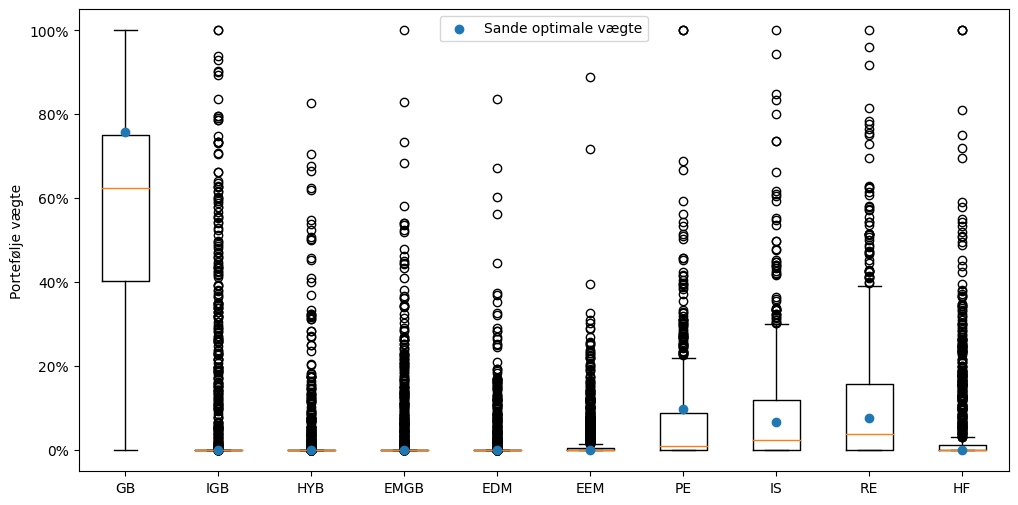

In [1106]:
# boxplot of simulated optimal portfolio weights

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(w_sim)
ax.scatter(np.arange(1, len(w_max_sr) + 1), w_max_sr, label="Sande optimale vægte", zorder=10)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xticklabels(assets)
ax.set_ylabel("Portefølje vægte")
ax.legend()
# plt.savefig("boxplot_optimal_weights.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [926]:
"""
bruger ikke denne til noget!
"""
# calculate ESTIMATED expected portfolio returns, std. and variances for simulated MV portfolios

mu_sim_est = np.ndarray([num_sim])
var_sim_est = np.ndarray([num_sim])

for k in range (num_sim):
    mu_sim_est[k] = portfolio_mean(w_sim[k], mu_est[k])
    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    var_sim_est[k] = portfolio_variance(w_sim[k], cov_mat_est)

std_sim_est = np.sqrt(var_sim_est)

In [11]:
# calculate actual expected monthly returns with simulated optimal weights
mu_sim = (mu[None, :] * w_sim[:, :]).sum(axis=1)
mu_sim

C:\Users\Majaw\AppData\Local\Temp\ipykernel_31124\3172890996.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mu_sim = (mu[None, :] * w_sim[:, :]).sum(axis=1)


array([0.0116544 , 0.01185497, 0.0089982 , 0.01087419, 0.01148366,
       0.01149554, 0.00967909, 0.00995689, 0.01102415, 0.01149683,
       0.00957003, 0.00981276, 0.01124036, 0.0114468 , 0.01133314,
       0.0111657 , 0.01283904, 0.008769  , 0.01066755, 0.00951715,
       0.01013035, 0.01005485, 0.00977975, 0.01180412, 0.01046617,
       0.01097486, 0.01051096, 0.0110416 , 0.01142892, 0.01098961,
       0.00993569, 0.01229937, 0.00961477, 0.01093568, 0.01207964,
       0.01179007, 0.01058084, 0.01035803, 0.00978054, 0.01052561,
       0.01143441, 0.01106422, 0.01122625, 0.00979096, 0.0100165 ,
       0.00930552, 0.01110302, 0.01097408, 0.01046829, 0.01058677,
       0.01050756, 0.01206293, 0.01065409, 0.01093182, 0.010251  ,
       0.01008075, 0.01015372, 0.01106427, 0.01034555, 0.01100506,
       0.01013286, 0.01160358, 0.01239483, 0.01246569, 0.00883572,
       0.01027498, 0.01091619, 0.01096727, 0.01155786, 0.01008054,
       0.01125956, 0.01067984, 0.01104717, 0.01139734, 0.00938

In [9]:
# calculate ACTUAL expected portfolio returns, std. and variance for the simulated MV portfolios

mu_sim = np.ndarray([num_sim])
var_sim = np.ndarray([num_sim])

for k in range (num_sim):
    mu_sim[k] = portfolio_mean(w_sim[k], mu)
    var_sim[k] = portfolio_variance(w_sim[k], cov_mat)

std_sim = np.sqrt(var_sim)

In [10]:
mu_sim

array([0.0116544 , 0.01185497, 0.0089982 , 0.01087419, 0.01148366,
       0.01149554, 0.00967909, 0.00995689, 0.01102415, 0.01149683,
       0.00957003, 0.00981276, 0.01124036, 0.0114468 , 0.01133314,
       0.0111657 , 0.01283904, 0.008769  , 0.01066755, 0.00951715,
       0.01013035, 0.01005485, 0.00977975, 0.01180412, 0.01046617,
       0.01097486, 0.01051096, 0.0110416 , 0.01142892, 0.01098961,
       0.00993569, 0.01229937, 0.00961477, 0.01093568, 0.01207964,
       0.01179007, 0.01058084, 0.01035803, 0.00978054, 0.01052561,
       0.01143441, 0.01106422, 0.01122625, 0.00979096, 0.0100165 ,
       0.00930552, 0.01110302, 0.01097408, 0.01046829, 0.01058677,
       0.01050756, 0.01206293, 0.01065409, 0.01093182, 0.010251  ,
       0.01008075, 0.01015372, 0.01106427, 0.01034555, 0.01100506,
       0.01013286, 0.01160358, 0.01239483, 0.01246569, 0.00883572,
       0.01027498, 0.01091619, 0.01096727, 0.01155786, 0.01008054,
       0.01125956, 0.01067984, 0.01104717, 0.01139734, 0.00938

In [12]:
# calculate ESTIMATED expected portfolio returns, std. and variance for optimal portfolio

mu_opt_sim = np.ndarray([num_sim])
var_opt_sim = np.ndarray([num_sim])

for k in range(num_sim):
    mu_opt_sim[k] = portfolio_mean(w_max_sr, mu_est[k])
    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    var_opt_sim[k] = portfolio_variance(w_max_sr, cov_mat_est)

std_opt_sim = np.sqrt(var_opt_sim)

NameError: name 'mu_sim_est' is not defined

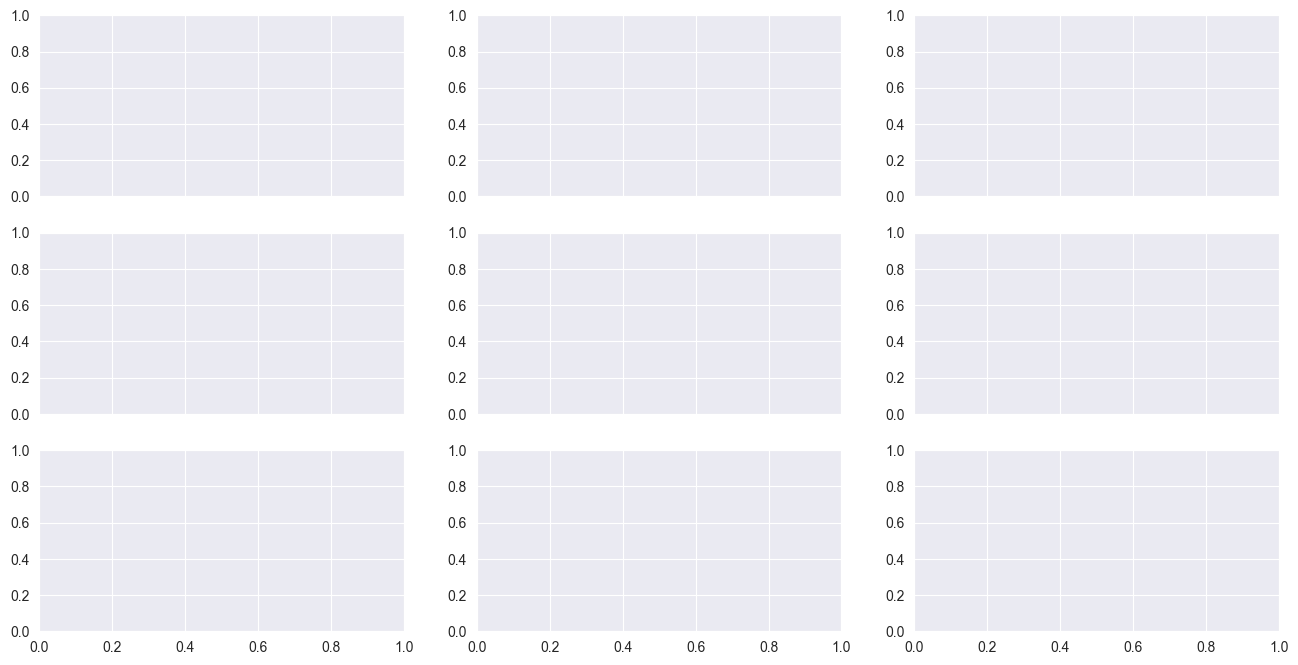

In [13]:
# plot histogram of estimated and actual expected return and std. for simulated portfolios + true optimal (CHANGE AXES TO PERCENT)
# fjern den øverste række af plots! det interessante er faktiske værdier på simulerede optimale vægte. og værdier for sande optimale vægte på simuleret data!
# kdeplots istedet! skal det være med nye data?

fig, ax = plt.subplots(3,3,figsize=(16,8), sharex='col', sharey='col')

# expected return
ax[0,0].hist(mu_sim_est, alpha=0.5,
        label="Estimerede", bins=40, density=True)
ax[0,0].axvline(mu_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0,0].legend()
ax[1,0].hist(mu_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[1,0].axvline(mu_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1,0].legend()
ax[2,0].hist(mu_opt_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[2,0].axvline(mu_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[2,0].legend()

# std.
ax[0,1].hist(std_sim_est, alpha=0.5,
        label="Estimerede", bins=40, density=True)
ax[0,1].axvline(std_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0,1].legend()
ax[1,1].hist(std_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[1,1].axvline(std_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1,1].legend()
ax[2,1].hist(std_opt_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[2,1].axvline(std_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[2,1].legend()

# Sharpe Ratio
ax[0,2].hist(sharpe_ratio(mu_sim_est, var_sim_est, 0), alpha=0.5,
        label="Estimerede", bins=40, density=True)
ax[0,2].axvline(sr_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0,2].legend()
ax[1,2].hist(sharpe_ratio(mu_sim, var_sim, 0), alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[1,2].axvline(sr_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1,2].legend()
ax[2,2].hist(sharpe_ratio(mu_opt_sim, var_opt_sim, 0), alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[2,2].axvline(sr_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[2,2].legend()

# labels and ticks
ax[0,0].set_ylabel("Tæthed")
ax[1,0].set_ylabel("Tæthed")
ax[1,0].set_xlabel("$\mu$ (forventet afkast) %")
ax[1,1].set_xlabel("$\sigma$ (standardafvigelse) %")
ax[1,2].set_xlabel("Sharpe Ratio")

# plt.savefig("simulation_histograms.jpg",bbox_inches="tight",dpi=300)
plt.show()

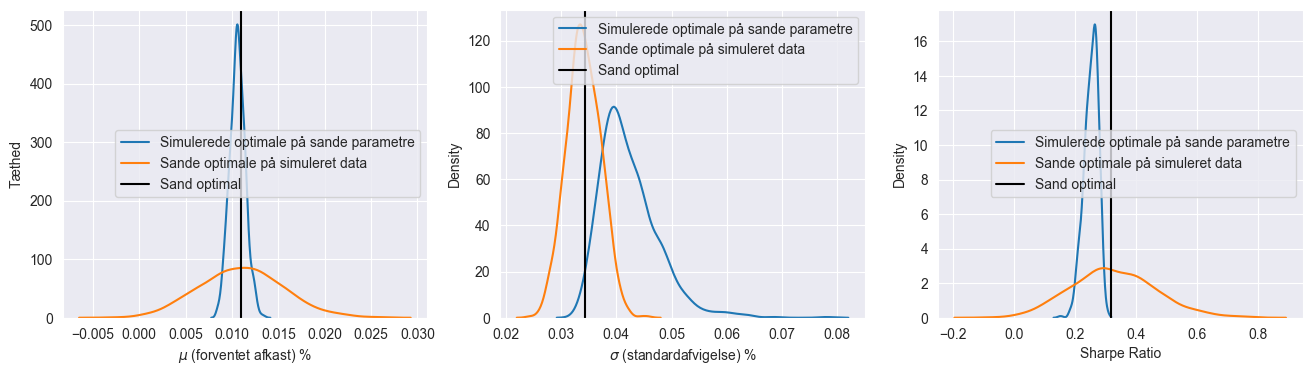

In [14]:
fig, ax = plt.subplots(1,3,figsize=(16,4), sharex='col', sharey='col')

# expected return
sns.kdeplot(mu_sim, label="Simulerede optimale på sande parametre", ax=ax[0])
sns.kdeplot(mu_opt_sim, label="Sande optimale på simuleret data", ax=ax[0])
ax[0].axvline(mu_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0].legend()

# std.
sns.kdeplot(std_sim, label="Simulerede optimale på sande parametre", ax=ax[1])
sns.kdeplot(std_opt_sim, label="Sande optimale på simuleret data", ax=ax[1])
ax[1].axvline(std_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1].legend()

# Sharpe Ratio
sns.kdeplot(mu_sim/std_sim, label="Simulerede optimale på sande parametre", clip=(0.0, sr_max_sr), ax=ax[2])
sns.kdeplot(mu_opt_sim/std_opt_sim, label="Sande optimale på simuleret data", ax=ax[2])
ax[2].axvline(sr_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[2].legend()

# labels and ticks
ax[0].set_ylabel("Tæthed")
ax[0].set_xlabel("$\mu$ (forventet afkast) %")
ax[1].set_xlabel("$\sigma$ (standardafvigelse) %")
ax[2].set_xlabel("Sharpe Ratio")

# plt.savefig("simulation_histograms.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [15]:
np.random.seed(2)
sim_data_new = np.random.multivariate_normal(mu_logreturns_monthly, cov_mat_logreturns_monthly, size=(num_sim, num_obs))
sim_data_new = np.exp(sim_data_new) - 1

# calculate portfolio returns
return_optimal = (sim_data_new[:, :, :] * w_max_sr[None, None, :]).sum(axis=2)
return_simulated = (sim_data_new[:, :, :] * w_sim[:, None, :]).sum(axis=2)

NameError: name 'mu_logreturns_monthly' is not defined

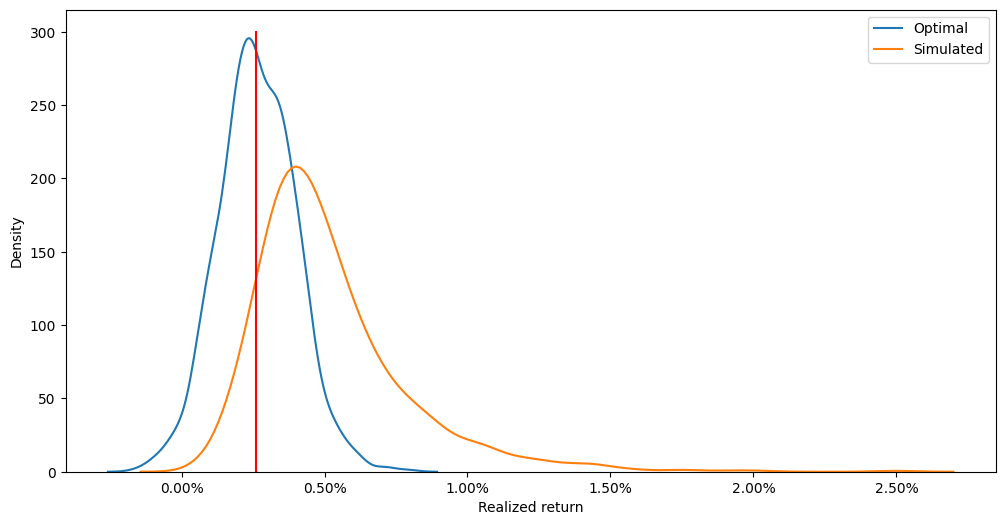

In [1099]:
# plot gennemsnitligt afkast over 60 måneder
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(np.mean(return_optimal, axis=1), label="Optimal");
sns.kdeplot(np.mean(return_simulated, axis=1), label="Simulated");
ax.plot([mu_max_sr, mu_max_sr], [0, 300], color="red")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Realized return");
ax.legend();

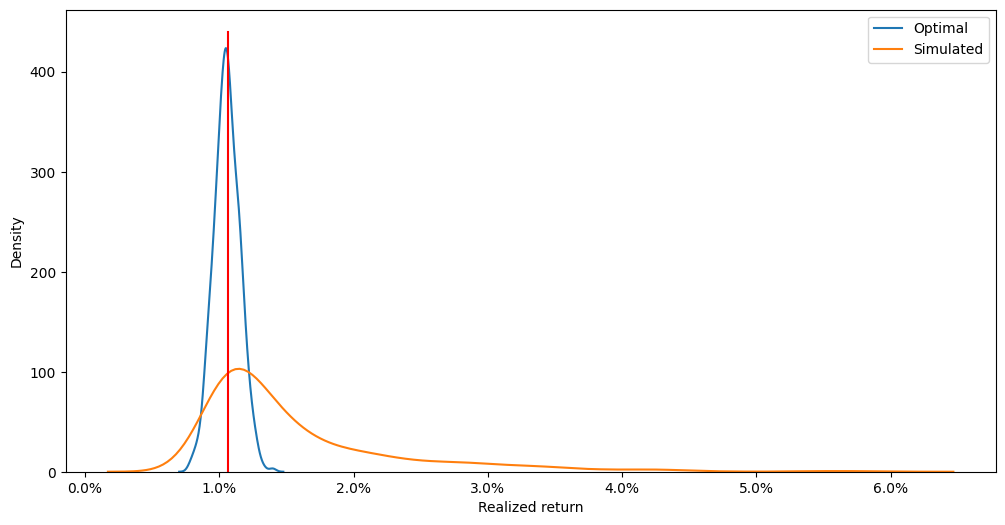

In [1014]:
# plot gennemsnitligt afkast over 60 måneder
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(np.std(return_optimal, axis=1), label="Optimal");
sns.kdeplot(np.std(return_simulated, axis=1), label="Simulated");
ax.plot([std_max_sr, std_max_sr], [0, 440], color="red")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Realized return");
ax.legend();

In [16]:
# calculate average of estimated return, variance, std. and SR for simulated MV portfolios

av_mu_sim_est = np.mean(mu_sim_est)
print(av_mu_sim_est)
av_var_sim_est = np.mean(var_sim_est)
print(av_var_sim_est)
av_std_sim_est = np.mean(std_sim_est)
print(av_std_sim_est)
sr_sim_est = (av_mu_sim_est - rf)/av_std_sim_est
print(sr_sim_est)

NameError: name 'mu_sim_est' is not defined

In [17]:
# calculate average of actual return, variance and SR for simulated portfolios

av_mu_sim = np.mean(mu_sim)
print(av_mu_sim)
av_var_sim = np.mean(var_sim)
print(av_var_sim)
av_std_sim = np.mean(std_sim)
print(av_std_sim)
sr_sim = (av_mu_sim - rf)/av_std_sim
print(sr_sim)

0.010608026993389093
0.0018173498265848607
0.04230492634601946
0.2507515769351344


In [18]:
# calculate true expected return, std. and variance and SR for equally weighted portfolio

equal_weights = np.repeat(1/num_assets, num_assets)

mu_eq_port = portfolio_mean(equal_weights, mu)
print(mu_eq_port)
var_eq_port = portfolio_variance(equal_weights, cov_mat)
print(var_eq_port)
std_eq_port = portfolio_std(equal_weights, cov_mat)
print(std_eq_port)
sr_eq_port = sharpe_ratio(mu_eq_port, var_eq_port, 0)
print(sr_eq_port)
mu_eq_port / std_eq_port

0.010218388550225284
0.002114253767722199
0.045981015296774376
0.2222305985257815


0.2222305985257815

# Calculate stats for T=100,300,500,1000

In [537]:
# simulate returns for (num_obs) t= 100, 300, 500, 1000 months
# find optimal portfolio weights for each simulation

num_sim = 500
num_obs = 1000 # months
T = [100, 300, 500, 1000]
np.random.seed(2)
sim_data_t = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

#w_sim_t = np.ndarray([len(T),num_sim,len(mu)])
w_sim_t = list([[],[],[],[]])
j = 0

for t in T:
    mu_est = np.mean(sim_data_t[:,:t,:], axis=1)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
                   {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

    equal_weights = np.ones_like(mu) / len(mu)

    for i in range(num_sim):

        cov_mat_est = np.cov(sim_data_t[i,:t,:], rowvar=False)

        res = minimize(fun = sharpe_ratio, args=(mu_est[i], cov_mat_est, rf),
                       x0 = equal_weights,
                       method = 'SLSQP',
                       constraints = constraints)
        w_sim_t[j].append(res.x)
        #print(res.x)
    j += 1
w_sim_t = np.array(w_sim_t)

In [538]:
# calculate ESTIMATED expected portfolio returns, std. and variances for simulated MV portfolios T=100,300,500,1000

mu_sim_est_t = np.ndarray([len(T),num_sim])
var_sim_est_t = np.ndarray([len(T),num_sim])
j = 0

for t in T:
    mu_est = np.mean(sim_data[:,:t,:], axis=1)
    for i in range (num_sim):
        mean = portfolio_mean(w_sim_t[j,i], mu_est[i])
        cov_mat_est = np.cov(sim_data[i,:t,:], rowvar=False)
        var = portfolio_variance(w_sim_t[j,i], cov_mat_est)
        mu_sim_est_t[j,i] = mean
        var_sim_est_t[j,i] = var
    j += 1

std_sim_est_t = np.sqrt(var_sim_est_t)

In [539]:
# calculate ACTUAL expected portfolio returns, std. and variance for the simulated MV portfolios

mu_sim_t = np.ndarray([len(T),num_sim])
var_sim_t = np.ndarray([len(T),num_sim])
j = 0

for t in T:
    for i in range (num_sim):
        mean = portfolio_mean(w_sim_t[j,i], mu)
        var = portfolio_variance(w_sim_t[j,i], cov_mat)
        mu_sim_t[j,i] = mean
        var_sim_t[j,i] = var
    j +=1

std_sim_t = np.sqrt(var_sim_t)

In [540]:
# calculate average of actual return, variance and SR for simulated portfolios

av_mu_sim_t = np.ndarray([4,1])
av_std_sim_t = np.ndarray([4,1])
sr_sim_t = np.ndarray([4,1])

for t in range(len(T)):
    av_mu_sim_t[t] = np.mean(mu_sim_t[t])
    print(av_mu_sim_t[t])
    #av_var_sim = np.mean(var_sim)
    #print(av_var_sim)
    av_std_sim_t[t] = np.mean(std_sim_t[t])
    print(av_std_sim_t[t])
    sr_sim_t[t] = (av_mu_sim_t[t] - rf) / av_std_sim_t[t]
    print(sr_sim_t[t])

[0.97234666]
[4.03600121]
[0.19262254]
[0.97076091]
[3.78494407]
[0.20498032]
[0.96736375]
[3.67189403]
[0.21036606]
[0.96403493]
[3.56819408]
[0.21554687]


In [541]:
sr_sim_t

array([[0.19262254],
       [0.20498032],
       [0.21036606],
       [0.21554687]])

In [542]:
# Make stats dataframe with mean and std. of estimated optimal portfolio parameters
# and actual optimal portfolio parameters

stats_table = pd.DataFrame(columns=['True Optimal', '60', '100', '300', '500', '1000'])

#portfolio weights
for i in range(len(mu)):
    stats_table.loc["$x_{}$".format(i+1),'True Optimal'] = np.round(np.abs(w_m[i]),3)
    stats_table.loc["$x_{}$".format(i+1),'60'] = np.round(np.mean(w_sim[:,i]),3)
    stats_table.loc["std_{}".format(i+1),'60'] = np.round(np.std(w_sim[:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'100'] = np.round(np.mean(w_sim_t[0,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'100'] = np.round(np.std(w_sim_t[0,:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'300'] = np.round(np.mean(w_sim_t[1,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'300'] = np.round(np.std(w_sim_t[1,:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'500'] = np.round(np.mean(w_sim_t[2,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'500'] = np.round(np.std(w_sim_t[2,:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'1000'] = np.round(np.mean(w_sim_t[3,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'1000'] = np.round(np.std(w_sim_t[3,:,i]),3)

#expected portfolio return
stats_table.loc["$\mu$",'True Optimal'] = np.round(mu_m,3)
stats_table.loc["$\mu$",'60'] = np.round(np.mean(mu_sim_est),3)
stats_table.loc["std mu",'60'] = np.round(np.std(mu_sim_est),3)
stats_table.loc["$\mu$",'100'] = np.round(np.mean(mu_sim_est_t[0]),3)
stats_table.loc["std mu",'100'] = np.round(np.std(mu_sim_est_t[0]),3)
stats_table.loc["$\mu$",'300'] = np.round(np.mean(mu_sim_est_t[1]),3)
stats_table.loc["std mu",'300'] = np.round(np.std(mu_sim_est_t[1]),3)
stats_table.loc["$\mu$",'500'] = np.round(np.mean(mu_sim_est_t[2]),3)
stats_table.loc["std mu",'500'] = np.round(np.std(mu_sim_est_t[2]),3)
stats_table.loc["$\mu$",'1000'] = np.round(np.mean(mu_sim_est_t[3]),3)
stats_table.loc["std mu",'1000'] = np.round(np.std(mu_sim_est_t[3]),3)

#portfolio variance
stats_table.loc["$\sigma$",'True Optimal'] = np.round(std_m,3)
stats_table.loc["$\sigma$",'60'] = np.round(np.mean(std_sim_est),3)
stats_table.loc["std sigma",'60'] = np.round(np.std(std_sim_est),3)
stats_table.loc["$\sigma$",'100'] = np.round(np.mean(std_sim_est_t[0]),3)
stats_table.loc["std sigma",'100'] = np.round(np.std(std_sim_est_t[0]),3)
stats_table.loc["$\sigma$",'300'] = np.round(np.mean(std_sim_est_t[1]),3)
stats_table.loc["std sigma",'300'] = np.round(np.std(std_sim_est_t[1]),3)
stats_table.loc["$\sigma$",'500'] = np.round(np.mean(std_sim_est_t[2]),3)
stats_table.loc["std sigma",'500'] = np.round(np.std(std_sim_est_t[2]),3)
stats_table.loc["$\sigma$",'1000'] = np.round(np.mean(std_sim_est_t[3]),3)
stats_table.loc["std sigma",'1000'] = np.round(np.std(std_sim_est_t[3]),3)

stats_table

,True Optimal,60,100,300,500,1000
$x_1$,0.199,0.151,0.166,0.175,0.179,0.182
std_1,NaN,0.251,0.247,0.209,0.196,0.155
$x_2$,0.0,0.036,0.022,0.011,0.004,0.001
std_2,NaN,0.104,0.07,0.036,0.019,0.006
$x_3$,0.0,0.042,0.039,0.038,0.028,0.019
std_3,NaN,0.145,0.112,0.096,0.074,0.056
$x_4$,0.007,0.101,0.08,0.057,0.049,0.037
std_4,NaN,0.181,0.141,0.093,0.079,0.055
$x_5$,0.095,0.096,0.096,0.095,0.088,0.089
std_5,NaN,0.162,0.169,0.118,0.098,0.085


In [543]:
a2l.to_ltx(stats_table,frmt='{:3.3f}', arraytype = 'bmatrix', print_out=True)

\begin{bmatrix}
 $x_1$ &  0.199 &  0.151 &  0.166 &  0.175 &  0.179 &  0.182\\
 std_1 &  nan  &  0.251 &  0.247 &  0.209 &  0.196 &  0.155\\
 $x_2$ &  0.000 &  0.036 &  0.022 &  0.011 &  0.004 &  0.001\\
 std_2 &  nan  &  0.104 &  0.070 &  0.036 &  0.019 &  0.006\\
 $x_3$ &  0.000 &  0.042 &  0.039 &  0.038 &  0.028 &  0.019\\
 std_3 &  nan  &  0.145 &  0.112 &  0.096 &  0.074 &  0.056\\
 $x_4$ &  0.007 &  0.101 &  0.080 &  0.057 &  0.049 &  0.037\\
 std_4 &  nan  &  0.181 &  0.141 &  0.093 &  0.079 &  0.055\\
 $x_5$ &  0.095 &  0.096 &  0.096 &  0.095 &  0.088 &  0.089\\
 std_5 &  nan  &  0.162 &  0.169 &  0.118 &  0.098 &  0.085\\
 $x_6$ &  0.000 &  0.021 &  0.012 &  0.003 &  0.000 &  0.000\\
 std_6 &  nan  &  0.076 &  0.051 &  0.018 &  0.002 &  0.001\\
 $x_7$ &  0.148 &  0.110 &  0.123 &  0.131 &  0.142 &  0.147\\
 std_7 &  nan  &  0.201 &  0.207 &  0.173 &  0.157 &  0.130\\
 $x_8$ &  0.249 &  0.192 &  0.219 &  0.234 &  0.242 &  0.241\\
 std_8 &  nan  &  0.261 &  0.266 &  0.210 &  0

# Plot results in graph with true efficient frontier

In [19]:
# calculate minimum variance portfolio

w_min_var = calculate_min_var_portfolio(cov_mat)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0009950370782520858
            Iterations: 59
            Function evaluations: 2951
            Gradient evaluations: 59


In [20]:
np.round(w_min_var,4)

array([0.0495, 0.1519, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.1663, 0.    , 0.    , 0.    , 0.1199, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.0641, 0.0376, 0.    , 0.    , 0.    , 0.3118, 0.0166,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0821, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    ])

In [21]:
mu_min_var = portfolio_mean(w_min_var, mu)
std_min_var = portfolio_std(w_min_var, cov_mat)

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_min_var[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, cov_mat)
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, mu)

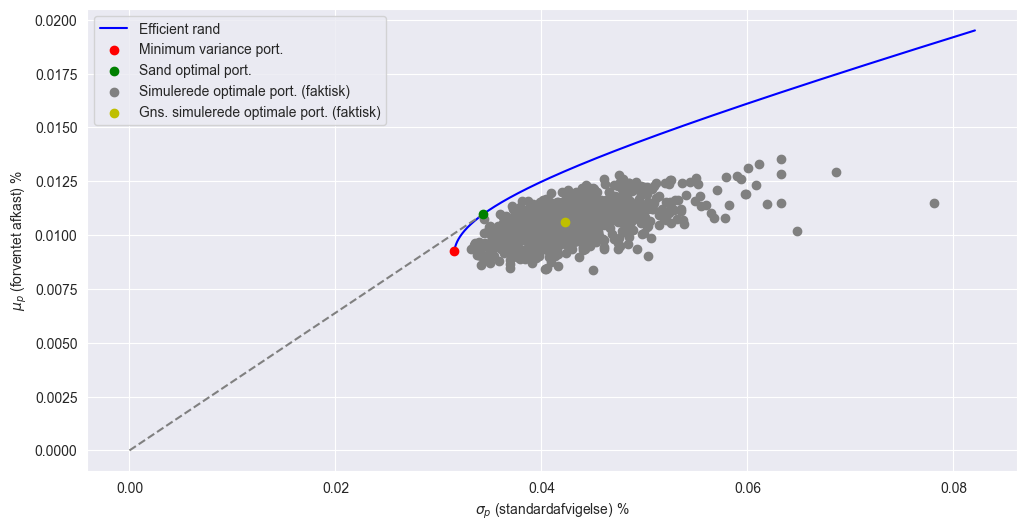

In [23]:
"""
Plot the efficient frontier
"""
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient rand")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_min_var, mu_min_var, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="Sand optimal port. ", zorder=10)
#ax.scatter(av_std_sim_est, av_mu_sim_est, color="black", label="Gns. simulerede optimale port. (estimeret)")
ax.scatter(std_sim, mu_sim, color="grey", label="Simulerede optimale port. (faktisk)")
ax.scatter(av_std_sim, av_mu_sim, color="y", label="Gns. simulerede optimale port. (faktisk)", zorder=10)
#ax.scatter(0, rf, color="y", label="Risikofrit afkast", zorder=10)

ax.set_xlabel("$\sigma_p$ (standardafvigelse) %")
ax.set_ylabel("$\mu_p$ (forventet afkast) %")

ax.legend();

# Print tables to Latex

In [888]:
np.array(list(assets))

array(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr',
       'Txtls', 'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq',
       'Autos', 'Aero', 'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil',
       'Util', 'Telcm', 'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips',
       'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals',
       'Banks', 'Insur', 'RlEst', 'Fin', 'Other'], dtype='<U5')

In [549]:
a2l.to_ltx(pd.DataFrame(assets).T, arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(np.array(mu), frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(np.tril(cov_mat), frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(w_m, frmt = '{:6.3f}', arraytype = 'bmatrix', print_out=True)

\begin{bmatrix}
 0 &  NoDur &  Durbl &  Manuf &  Enrgy &  HiTec &  Telcm &  Shops &  Hlth &  Utils &  Other
\end{bmatrix}
\begin{bmatrix}
    0.92 &    1.04 &    1.03 &    1.01 &    1.22 &    0.69 &    1.01 &    1.00 &    0.85 &    0.95
\end{bmatrix}
\begin{bmatrix}
   14.40 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   15.26 &   64.99 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   13.53 &   28.89 &   23.42 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   11.79 &   23.83 &   20.02 &   43.54 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   11.70 &   33.01 &   22.96 &   16.87 &   46.22 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   11.60 &   22.12 &   16.68 &   15.34 &   22.94 &   25.79 &    0.00 &    0.00 &    0.00 &    0.00\\
   12.01 &   25.93 &   17.28 &   12.28 &   21.70 &   15.16 &   21.30 &    0.00 &    0.00 &    0.00\\
   10.82 &   15.04 &   12.

# Principal komponentporteføljer

In [ ]:
# function to project weights into v-space:
def weights_in_pc_space(weights: np.ndarray, principal_components: np.ndarray, vols_mat: np.ndarray) -> np.ndarray:


In [24]:
def calculate_mu_and_var_pcp(mu, cov_mat, r=0):

    # decompose covariance matrix
    vols = np.sqrt(np.diag(cov_mat))
    vols_mat = np.diag(vols)
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1  # numerical error

    #eigenvalue decomposition of correlationmatrix
    D, V = np.linalg.eig(corr_mat)
    # sort eigenvalues and eigenvector in decending order
    idx = D.argsort()[::-1]
    D = D[idx]
    V = V[:,idx]
    D = np.diag(D)

    # calculate expected returns and vols for principalcomponent portfolios
    mu_V = V.T @ np.linalg.inv(vols_mat) @ mu
    std_V = np.diag(np.sqrt(D))

    return mu_V,std_V, D, V


def calculate_max_sharpe_pcp(mu, cov_mat, r=0):

    # decompose covariance matrix
    vols = np.sqrt(np.diag(cov_mat))
    vols_mat = np.diag(vols)
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1  # numerical error

    #eigenvalue decomposition of correlationmatrix
    D, V = np.linalg.eig(corr_mat)
    # sort eigenvalues and eigenvector in decending order
    idx = D.argsort()[::-1]
    D = D[idx]
    V = V[:,idx]
    D = np.diag(D)

    # calculate expected returns and vols for principalcomponent portfolios
    mu_V = V.T @ np.linalg.inv(vols_mat) @ mu

    z = (np.linalg.inv(D) @ mu_V) / np.sum(np.linalg.inv(vols_mat) @ V @ np.linalg.inv(D) @ mu_V)
    mu_z = z.T @ np.diag(mu_V)
    var_z = (z.T @ np.sqrt(D))**2
    return z, mu_z, var_z

In [65]:
mu_V, std_V, D, V = calculate_mu_and_var_pcp(mu, cov_mat, 0)

In [66]:
# calculate optimal weights (expected return, variances and std.)  in PC-space:
z, mu_z, var_z  = calculate_max_sharpe_pcp(mu, cov_mat, 0)
std_z = np.sqrt(var_z)

In [67]:
# optimal weights (long only constraint) in PC space:
z = V @ vols_mat @ w_max_sr

In [77]:
# calculate true optimal risk allocation
vols_z = np.diag(np.diag(z) @ np.sqrt(D))**2
vols_z

array([3.41079900e-04, 1.33119815e-04, 1.07333991e-05, 7.70682007e-06,
       3.31182766e-06, 5.00225536e-06, 2.51249104e-06, 1.68391519e-06,
       1.80054994e-05, 1.41897613e-06, 2.07615081e-05, 4.74423068e-06,
       4.33252252e-06, 1.88855881e-08, 6.24157970e-06, 6.92651530e-06,
       6.21601996e-06, 6.92180113e-10, 5.64440397e-07, 1.30088740e-08,
       1.76063943e-06, 3.73292529e-06, 2.67508786e-07, 1.01957904e-07,
       6.99216640e-07, 7.30517057e-06, 3.38160073e-07, 4.19724650e-07,
       1.15049186e-06, 4.76602650e-07, 5.29348615e-06, 1.32405640e-06,
       5.05329058e-06, 1.85752326e-06, 3.37380369e-08, 2.18321289e-06,
       3.81892907e-07, 3.40557246e-07, 2.86700665e-07, 3.93541619e-07,
       8.41972379e-08, 4.01002513e-08, 1.05268351e-06, 2.69550074e-06,
       2.87172503e-07, 1.24867239e-07, 1.51732985e-06, 3.00399061e-07,
       6.81455956e-08])

In [78]:
# calculate actual risk allocations for simulated optimal portfolios
z_sim = V[None,:,:] @ vols_mat[None,:,:] @ w_sim[:,:].T
vols_z_sim = (z_sim[0,:].T @ np.sqrt(D[None,:,:]))**2
vols_z_sim= np.mean(vols_z_sim[0], axis=0)
vols_z_sim

array([2.69370184e-04, 3.32354345e-05, 6.93860566e-05, 2.68933883e-05,
       2.03362759e-05, 1.37480776e-05, 8.81167836e-06, 2.16526290e-05,
       9.92178420e-06, 1.21678549e-05, 9.30428194e-06, 1.28198692e-05,
       1.19173436e-05, 1.65586417e-05, 1.29418428e-05, 7.39741011e-06,
       7.87934116e-06, 7.25870751e-06, 1.61491197e-05, 4.69567745e-06,
       6.01742213e-06, 5.41601881e-06, 7.88740728e-06, 4.73207579e-06,
       3.95874878e-06, 8.02924884e-06, 4.06849214e-06, 3.51775367e-06,
       5.70260913e-06, 8.95055149e-06, 6.55916189e-06, 2.29148964e-06,
       5.24519071e-06, 3.57506324e-06, 4.25556206e-06, 4.03356054e-06,
       2.79464116e-06, 3.73085210e-06, 3.72642976e-06, 2.35742660e-06,
       1.84103486e-06, 2.67272621e-06, 1.34993461e-06, 1.36935479e-06,
       2.38555315e-06, 1.41372666e-06, 1.01818639e-06, 1.35914424e-06,
       1.15145877e-06])

In [1207]:
# calculate realized risk allocation for true optimal weights on simulated data
vols_z = np.diag(np.diag(z) @ np.sqrt(D))**2

In [71]:
# calculate simulated return and std. of optimal allocation in PC-space

num_sim = 1000
num_obs = 60 # months
np.random.seed(2)
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

# estimate expected return af std. of PCP's for each simulation
mu_V_sim = np.zeros((num_sim, num_assets))
std_V_sim = np.zeros((num_sim, num_assets))
z_sim = np.zeros((num_sim, num_assets))
mu_z_sim = np.zeros((num_sim, num_assets))
var_z_sim = np.zeros((num_sim, num_assets))
D_sim = np.zeros((num_sim,num_assets, num_assets))

mu_est = np.mean(sim_returns, axis=1)

for k in range(num_sim):

    cov_mat_est = np.cov(sim_returns[k], bias = True, rowvar=False)
    mu_V_sim[k,:], std_V_sim[k,:], D_sim[k,:,:], V = calculate_mu_and_var_pcp(mu_est[k],cov_mat_est,0)
    z_sim[k,:], mu_z_sim[k,:], var_z_sim[k,:]  = calculate_max_sharpe_pcp(mu_est[k], cov_mat_est, 0)

In [1186]:
"""Simulation med log-afkast (parametre fra afkastforventninger)"""
# calculate expected return and std. of PC portfolios (for true parameters and simulated)

mu_V, std_V = calculate_mu_and_var_pcp(mu,cov_mat,0)

num_sim = 1000
num_obs = 60 # months
np.random.seed(2)
sim_log_returns = np.random.multivariate_normal(mu_logreturns_monthly, cov_mat_logreturns_monthly, size=(num_sim, num_obs))
sim_returns = np.exp(sim_log_returns) - 1

# estimate expected return af std. of PCP's for each simulation
mu_V_sim = np.zeros((num_sim, num_assets))
std_V_sim = np.zeros((num_sim, num_assets))
mu_est = np.mean(sim_returns, axis=1)

for k in range(num_sim):

    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    mu_V_sim[k,:], std_V_sim[k,:] = calculate_mu_and_var_pcp(mu_est[k],cov_mat_est,0)

ValueError: too many values to unpack (expected 2)

In [72]:
"Calculate average of simulated expected return and std. for PC portfolios"
av_mu_V_sim = np.mean(mu_V_sim, axis=0)
av_std_V_sim = np.mean(std_V_sim, axis=0)

In [73]:
# calculate annulized PC sharpe ratios for true parameters and average of estimated
SR_V = np.abs(mu_V/std_V * np.sqrt(12))
SR_V_sim = np.mean(np.abs(mu_V_sim/std_V_sim), axis=0) * np.sqrt(12)

In [1221]:
np.diag(np.diag(z) @ np.sqrt(D))**2

array([4.09834004e-04, 9.22245431e-05, 3.34220653e-05, 1.36256939e-04,
       6.58698305e-06, 2.80011588e-06, 7.19992944e-07, 2.59759732e-05,
       2.35776514e-05, 4.48490105e-05, 1.17302529e-04, 3.64646389e-05,
       1.75805098e-05, 7.25251003e-06, 4.04396172e-05, 1.25916840e-05,
       8.68949622e-08, 3.04356131e-05, 1.66012636e-05, 1.33882045e-05,
       3.82434729e-05, 2.18039246e-05, 5.28068540e-08, 5.54414368e-05,
       3.32574941e-07, 2.30587730e-05, 1.83129104e-05, 5.13337338e-08,
       3.64695339e-06, 2.93393242e-05, 2.35477319e-05, 5.55779438e-05,
       1.62627944e-05, 1.31634421e-04, 4.80427605e-05, 1.11749844e-05,
       2.50136626e-05, 2.92846212e-05, 2.92899618e-05, 1.00190923e-06,
       4.87344810e-07, 1.16698763e-05, 1.15171277e-05, 9.46389750e-05,
       1.27327575e-05, 7.64902167e-05, 9.17569581e-06, 6.70845092e-06,
       4.20492958e-06])

In [1223]:
vols_z = (z.T[None, :] @ np.sqrt(D_sim[:,:,:]))**2

In [1251]:
vols_z = np.mean(np.mean(vols_z,axis=1),axis=0)

In [1246]:
vols_z_sim = (z_sim[:,:] @ np.sqrt(D[None,:,:]))**2

In [1252]:
vols_z_sim = np.mean(np.mean(vols_z_sim,axis=1),axis=0)

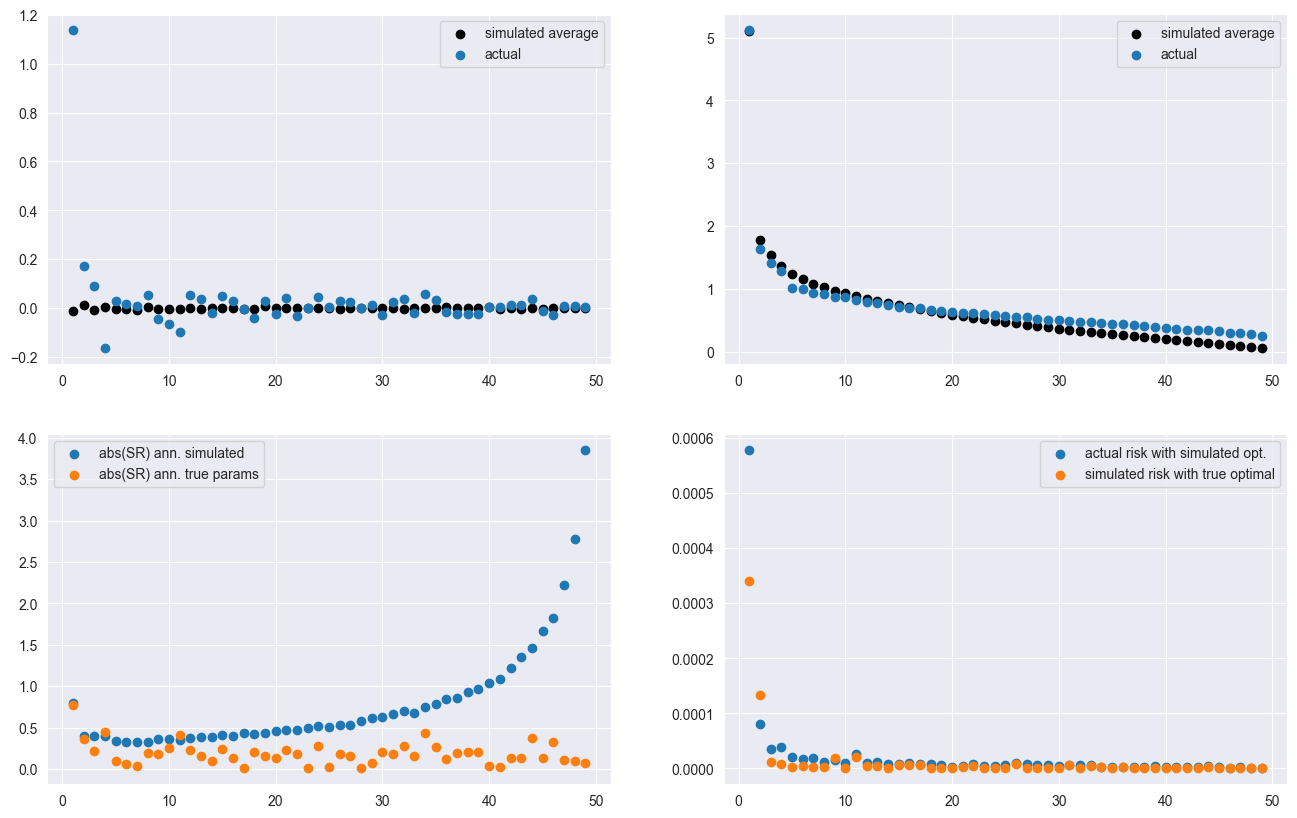

In [76]:
# plots
principal_components = np.linspace(1,num_assets,num_assets)

fig, ax = plt.subplots(2, 2,figsize=(16,10))

ax[0,0].scatter(principal_components, av_mu_V_sim, color='black', label='simulated average')
ax[0,0].scatter(principal_components, mu_V, label='actual')

ax[0,1].scatter(principal_components, av_std_V_sim, color='black', label='simulated average')
ax[0,1].scatter(principal_components, std_V, label='actual')

ax[1,0].scatter(principal_components, SR_V_sim, label='abs(SR) ann. simulated')
ax[1,0].scatter(principal_components, SR_V, label='abs(SR) ann. true params')

ax[1,1].scatter(principal_components, vols_z_sim, label='actual risk with simulated opt.')
ax[1,1].scatter(principal_components, vols_z, label='simulated risk with true optimal')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()

In [1198]:
# optimal portefølje uden long-only constraint:
x = np.linalg.inv(cov_mat) @ mu / (np.sum(np.linalg.inv(cov_mat) @ mu))
x

array([ 0.07268998, -0.06744234,  0.05306393, -0.02100113,  0.1393551 ,
       -0.26285609, -0.05773635,  0.00678516,  0.14927349,  0.12180111,
       -0.08934962,  0.12817141,  0.22550263, -0.15940149,  0.28070548,
       -0.04007318, -0.13427551, -0.10580515, -0.19342519,  0.02238796,
        0.12651727,  0.00223596,  0.02395231,  0.05979878,  0.04266296,
        0.33073642, -0.01277036,  0.21648493, -0.00534625,  0.0736808 ,
        0.30988324, -0.21460526, -0.24054012, -0.26495132, -0.16644616,
        0.34003265,  0.16178783,  0.14120871, -0.11273888, -0.15547389,
        0.1342699 , -0.14166046,  0.21169386,  0.1930408 ,  0.11378012,
        0.20833132, -0.0654363 ,  0.08108565, -0.45958469])

In [1199]:
x.T @ cov_mat @ x

0.0018571304184434858

In [637]:
z_x = V.T @ vols_mat @ x
print(z_x)
z_x.T @ D @ z_x # total varians for portefølje x
print(np.sum((z_x.T @ np.sqrt(D))**2)) # total varians er sum af varians fra hver PC)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 49)

In [163]:
z.T @ mu_V

0.0026950823306193814

In [164]:
(z.T @ mu_V) / np.sqrt(z.T @ D @ z)

0.255922594309101

In [178]:
np.sum(np.linalg.inv(vols) @ V @ np.linalg.inv(D) @ mu_V)

24.302179393105416

In [173]:
np.sum(np.linalg.inv(D) @ mu_V)

-0.3308289773120046

In [180]:
np.linalg.inv(D) @ mu_V

array([-0.07100568,  0.05589989, -0.1082443 , -0.00278229, -0.06368906,
        0.17752662,  0.05885335, -0.02899202, -0.05703495, -0.29136056])

In [186]:
z = (np.linalg.inv(D) @ mu_V) / np.sum(np.linalg.inv(vols) @ V @ np.linalg.inv(D) @ mu_V)
z

array([-0.00292178,  0.0023002 , -0.0044541 , -0.00011449, -0.00262071,
        0.00730497,  0.00242173, -0.00119298, -0.00234691, -0.01198907])

In [184]:
z @ mu_V

0.002695082330619375

In [185]:
(z @ mu_V) / np.sqrt(z.T @ D @ z)

0.255922594309101